In [1]:
"""
 * @ Author: Lucas Glasner (lgvivanco96@gmail.com)
 * @ Create Time: 1969-12-31 21:00:00
 * @ Modified by: Lucas Glasner, 
 * @ Modified time: 2024-05-09 16:15:52
 * @ Description:
 * @ Dependencies:
 */
"""
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from src.misc import to_numeric

import glob
import os

In [2]:
params  = pd.read_csv('data/params.csv', index_col=0)
params  = params.map(lambda x: to_numeric(x))

basin_paths  = [f'data/Basins/{n}/tmp/SDH-Run_{n}.nc' for n in params.loc['name']]
basin_names  = params.loc['name'].values
sdh_UHmodels  = {fid:xr.open_dataset(f'{p}',decode_timedelta=False).load()
                 for p,fid in zip(basin_paths,params.columns)}
# sdh_QRational = {fid:pd.read_excel(f'{p}/QRational_{n}.xlsx', index_col=0,
#                                  sheet_name='peakrunoff_m3s')
#                  for p,n,fid in zip(basin_paths, basin_names, params.columns)}


<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\3801556526.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$m^3 \cdot s^{-1} \cdot mm^{-1}$')


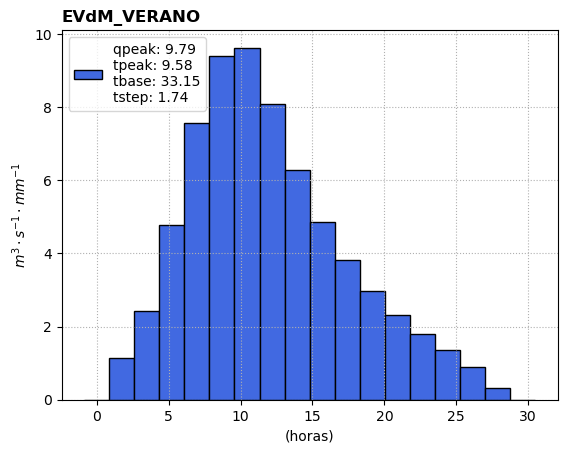

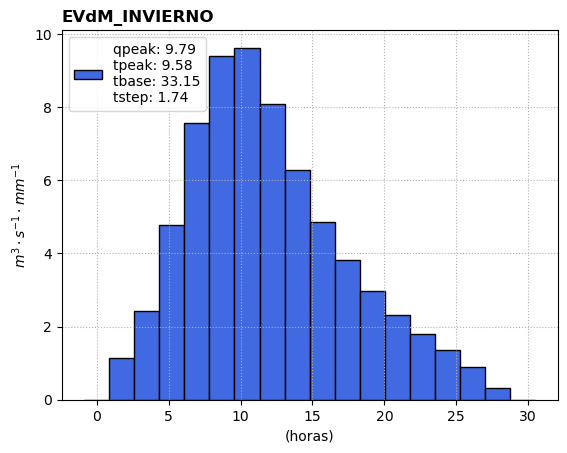

In [3]:
# ------------------------- plot and save hydrograph ------------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid]
    name = params[fid].loc['name'].replace(' ','')
    plt.figure(num=i)
    label = '\n'.join([f'{key}: {val}'
                    for key, val in sim.UnitHydro.attrs.items()][-4:])
    plt.xlabel('(horas)')
    plt.ylabel('$m^3 \cdot s^{-1} \cdot mm^{-1}$')
    plt.grid(True, ls=":")
    plt.bar(sim.UnitHydro.time, sim.UnitHydro.values,
            width=sim.UnitHydro.attrs['tstep'],
            color='royalblue',
            ec='k',
            label=label)
    plt.legend()
    plt.title(name, loc='left', weight='bold')
    plt.savefig(f'data/Basins/{name}/{name}_UnitHydrograph.png',
                dpi=125, bbox_inches='tight')

<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\287276114.py:22: SyntaxWarning: invalid escape sequence '\c'
  ax[0,0].set_ylabel('Precipitacion\n$(mm\cdot hr^{-1})$')
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\287276114.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax[1,0].set_ylabel('Precipitacion Efectiva\n$(mm\cdot hr^{-1})$')


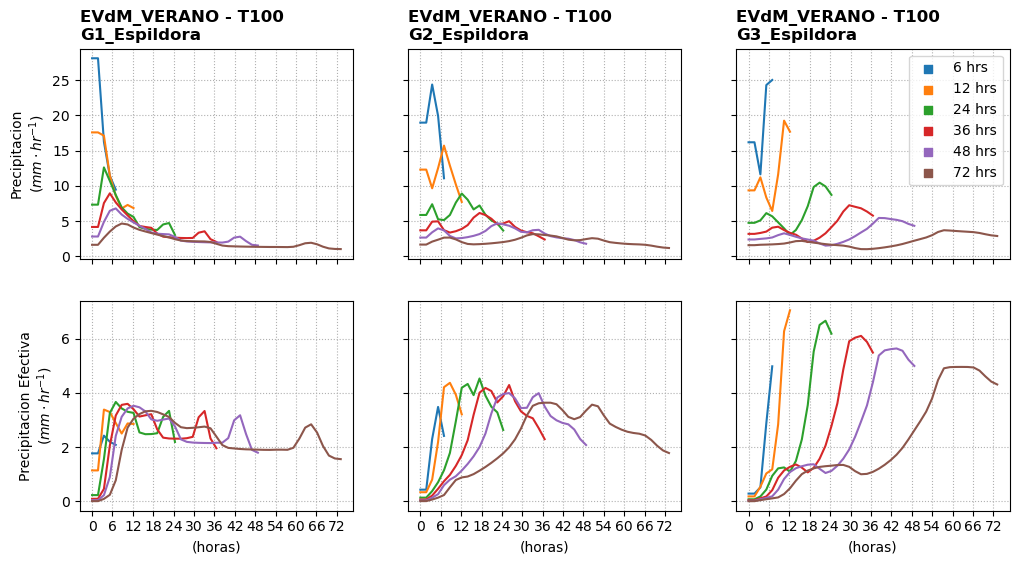

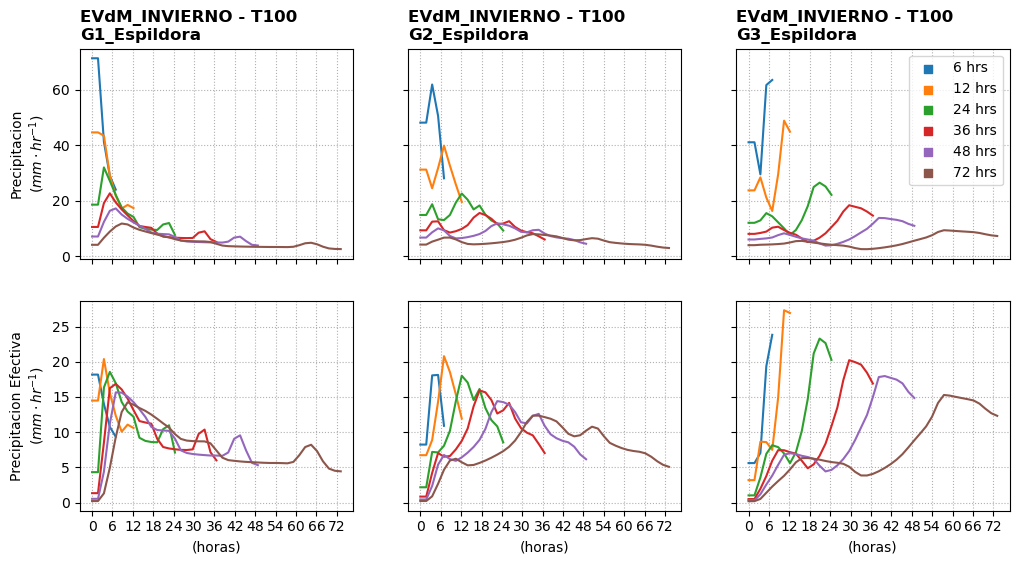

In [4]:
# --------------------------- plot design storms - --------------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid].sel(return_period=100,
                              storm_duration=[6,12,24,36,48,72])
    basin_name = params[fid].loc['name'].replace(' ','')
    n_dstorms = sim.shyeto.shape[0]
    fig, ax = plt.subplots(2, n_dstorms, figsize=(n_dstorms*4, 6),
                           sharex=True, sharey='row')
    for j, shyeto in enumerate(sim.shyeto):
        ax[0,j].set_title(f'{basin_name} - T100\n{shyeto.item()}', loc='left',
                          weight='bold')
        pr = sim.pr.sel(shyeto=shyeto).to_dataframe()['pr'].unstack().T
        ax[0,j].plot(pr.index,pr)
        
        pr = sim.pr_eff.sel(shyeto=shyeto).to_dataframe()['pr_eff'].unstack().T
        ax[1,j].plot(pr.index,pr)
        ax[1,j].set_xlabel('(horas)')
    
    for axis in ax.ravel():
        axis.set_xticks(np.arange(0,72+6,6))
        axis.grid(True, ls=":")
    ax[0,0].set_ylabel('Precipitacion\n$(mm\cdot hr^{-1})$')
    ax[1,0].set_ylabel('Precipitacion Efectiva\n$(mm\cdot hr^{-1})$')
    for k,dt in enumerate(sim.storm_duration):
        ax[0,-1].scatter([], [], label=f'{dt.item()} hrs', marker='s')
    ax[0,-1].legend()
    plt.savefig(f'data/Basins/{basin_name}/tmp/{basin_name}_DesignStorms.png',
                dpi=125, bbox_inches='tight')

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\1116946526.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_ylabel('Q Peak\n$(m^3\cdot s^{-1})$')


EVdM_Verano 36
EVdM_Invierno 24


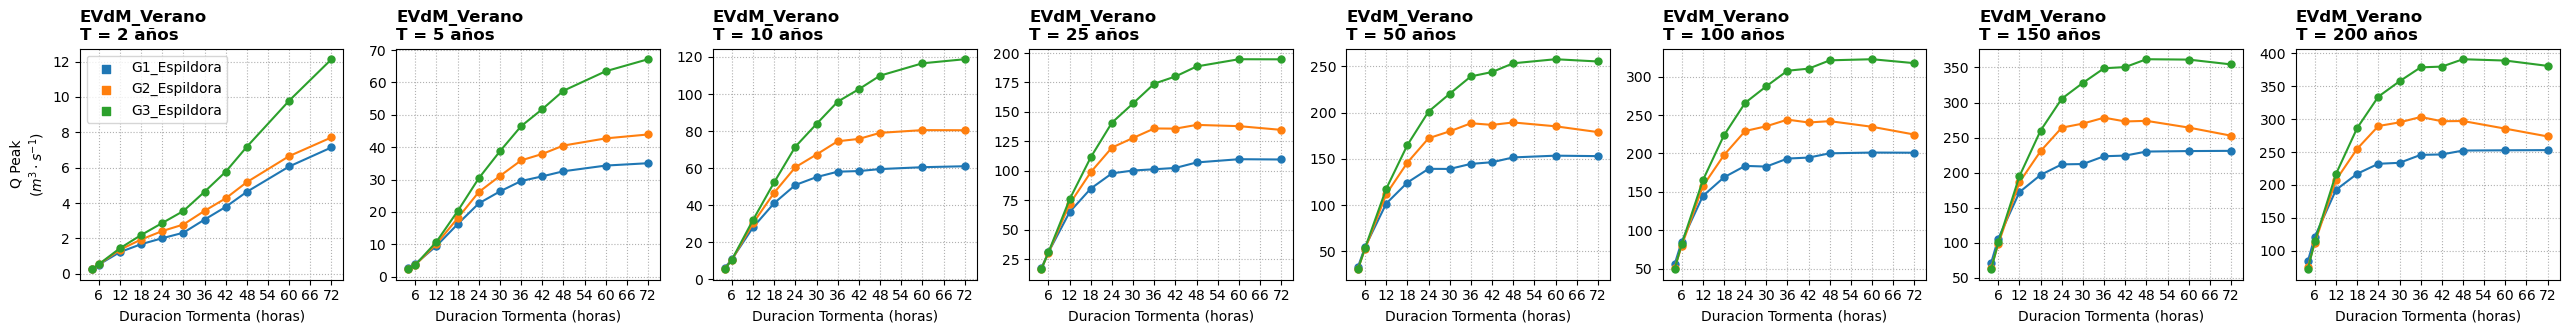

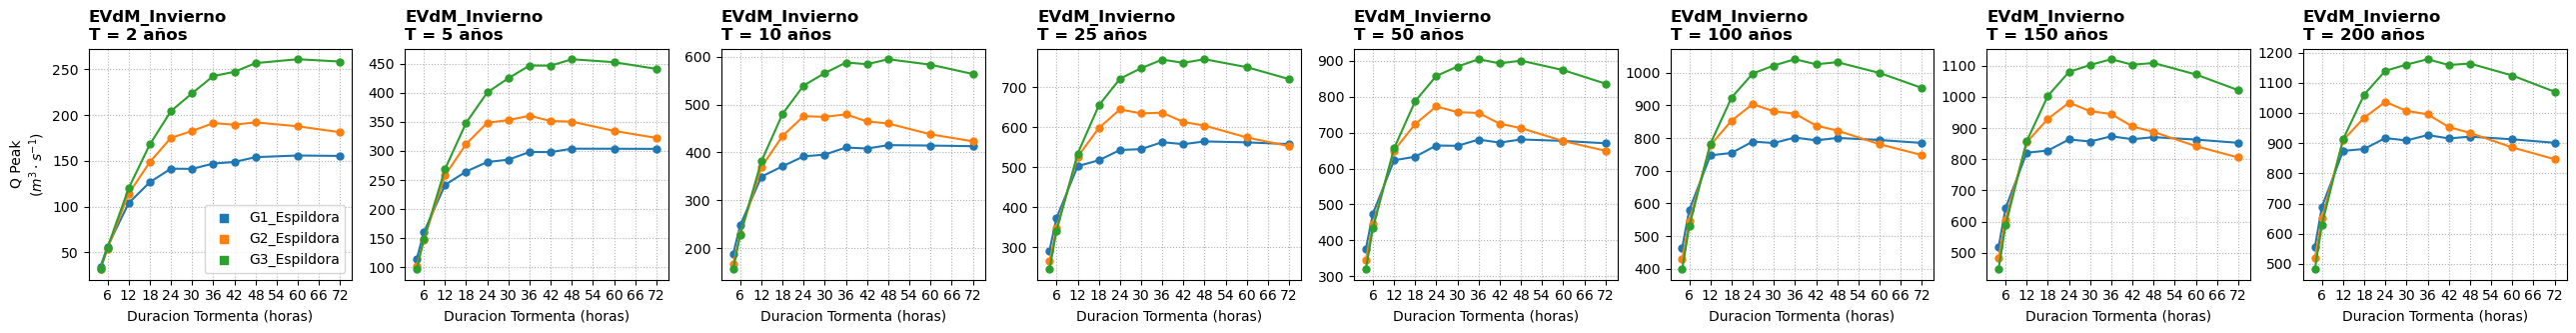

In [5]:
# ----------------------- plot peak hydrograph runoffs ----------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid]
    basin_name = sim.attrs['name'].replace(' ','')
    qpeak = sim.runoff.max('time')
    n_returnp = sim.return_period.shape[0]
    fig, ax = plt.subplots(1, n_returnp, figsize=(n_returnp*4, 3),
                           sharex=True, sharey=False)
    for j, T in enumerate(sim.return_period):
        q = qpeak.sel(return_period=T)
        q = q.to_dataframe()['runoff'].unstack()
        ax[j].plot(q.index, q, marker='o', markersize=5)
        ax[j].set_xticks(np.arange(0,72+6,6))
        ax[j].grid(True, ls=":")
        ax[j].set_xlabel('Duracion Tormenta (horas)')
        ax[j].set_title(f'{basin_name}\nT = {T.item()} años',
                        loc='left', weight='bold')
        if T == 100:
            print(basin_name,q['G2_Espildora'].idxmax())
    for k,shyeto in enumerate(sim.shyeto):
        ax[0].scatter([], [], label=shyeto.item(), marker='s')
    ax[0].legend()
    ax[0].set_ylabel('Q Peak\n$(m^3\cdot s^{-1})$')
    plt.savefig(f'data/Basins/{basin_name}/tmp/{basin_name}_PeakRunoffs.png',
                dpi=125, bbox_inches='tight')


In [6]:
# ----------- plot desired design hydrograph for all return periods ---------- #
design_durations = pd.Series([24,24],
                             index=params.columns, name='storm_duration_hr')
hyetographs      = pd.Series(['G2_Espildora']*len(params.columns),
                             index=params.columns)
q100max = []
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid]
    sim = sim.sel(shyeto=hyetographs[fid],
                  storm_duration=design_durations.loc[fid],
                  time=slice(0,design_durations.loc[fid]*2.25),
                  return_period=100)
    q100max.append(sim.runoff.max().item())
q100max = pd.Series(q100max, index=params.columns)#.sort_values()
design_durations = design_durations.loc[q100max.index]
hyetographs = hyetographs.loc[q100max.index]

<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:46: SyntaxWarning: invalid escape sequence '\c'
<>:53: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:46: SyntaxWarning: invalid escape sequence '\c'
<>:53: SyntaxWarning: invalid escape sequence '\c'
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\2586779817.py:41: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('$(m^3\cdot s^{-1})$')
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\2586779817.py:46: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$(mm\cdot hr^{-1})$')
C:\Users\felip\AppData\Local\Temp\ipykernel_20948\2586779817.py:53: SyntaxWarning: invalid escape sequence '\c'
  ax3.set_ylabel('$(mm\cdot hr^{-1})$')


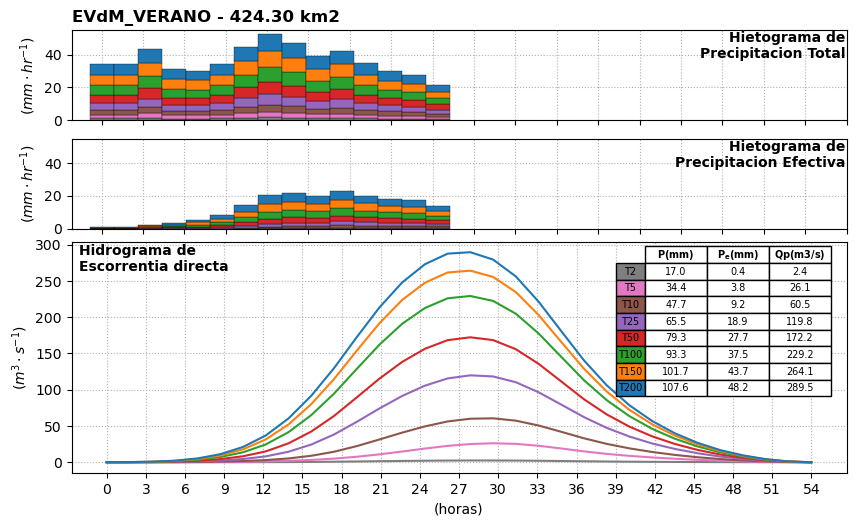

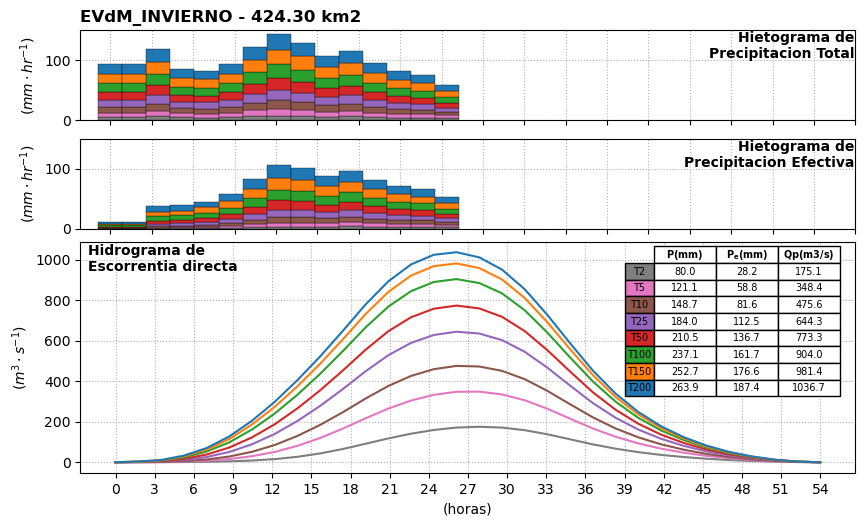

In [7]:
sims = []
for i,fid in enumerate(params.columns):
    # Load simulation
    name = params[fid].loc['name'].replace(' ','')
    sim = sdh_UHmodels[fid]
    
    # Select unit hydrograph
    uh = sim.UnitHydro.to_series().dropna()
    uh.name = sim.UnitHydro.standard_name+'  '+sim.UnitHydro.units
        
    # Select target duration and hyetograph
    sim = sim.sel(shyeto=hyetographs[fid],
                  storm_duration=design_durations.loc[fid],
                  time=slice(0,design_durations.loc[fid]*2.25))
    sim = sim.to_dataframe()[['pr','pr_eff','runoff']].unstack(0)
    colors = plt.cm.tab10(np.linspace(0,1,10))[:sim.pr.columns.shape[0]][::-1]
    
    sims.append(sim.runoff.max(axis=0))
    # Plot
    fig = plt.figure(figsize=(10,3))
    ax  = fig.add_subplot(111)
    ax.set_xticks(np.arange(0,np.ceil(sim.index.max())+3,3))
    ax.grid(True, ls=":")

    box = ax.get_position()
    ax2 = fig.add_axes([box.xmin, box.ymax*1.05, box.xmax-box.xmin, 0.3])
    ax3 = fig.add_axes([box.xmin, ax2.get_position().ymax*1.05,
                        box.xmax-box.xmin, 0.3])

    for i in range(len(sim.pr_eff.columns)):
        qpeak = sim.runoff.iloc[:,i].max()
        width = sim.index[1]-sim.index[0]
        ax.plot(sim.index,sim.runoff.iloc[:,i], color=colors[i])
        ax2.bar(sim.index,sim.pr_eff.iloc[:,i],
                bottom=sim.pr_eff.iloc[:,:i].sum(axis=1),
                width=width, ec='k', zorder=10, color=colors[i], lw=0.25)
        ax3.bar(sim.index,sim.pr.iloc[:,i],
                bottom=sim.pr.iloc[:,:i].sum(axis=1),
                width=width, ec='k', zorder=10, color=colors[i], lw=0.25)
    ax.set_xlabel('(horas)')
    ax.set_ylabel('$(m^3\cdot s^{-1})$')
    
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels([]);
    ax2.grid(True, ls=":", zorder=0)
    ax2.set_ylabel('$(mm\cdot hr^{-1})$')
    ax2.sharey(ax3)
    
    ax3.set_xticks(ax.get_xticks())
    ax3.set_xticklabels([]);
    ax3.grid(True, ls=":", zorder=0)
    
    ax3.set_ylabel('$(mm\cdot hr^{-1})$')
    ax3.set_title(f'{name} - {params[fid].area_km2:.2f} km2',
                  loc='left', weight='bold')
    ax3.text(0.999,0.99,'Hietograma de\nPrecipitacion Total', weight='bold',
            ha='right', va='top', transform=ax3.transAxes)
    ax2.text(0.999,0.99,'Hietograma de\nPrecipitacion Efectiva', weight='bold',
            ha='right', va='top', transform=ax2.transAxes)
    ax.text(0.01,0.99, 'Hidrograma de\nEscorrentia directa\n',
            ha='left', va='top', transform=ax.transAxes,
            weight='bold')
    
    table = pd.concat([sim.pr.sum(), sim.pr_eff.sum(), sim.runoff.max()],
                      axis=1).round(1)
    table.index = [f'T{x}' for x in table.index]
    table.index.name = ''
    table.columns = ['$\\bf{P (mm)}$', '$\\bf{P_e (mm)}$', '$\\bf{Qp (m3/s)}$']
    
    table = ax.table(cellText=table.values, 
            rowLabels=table.index, rowColours=colors,
            colLabels=table.columns, colWidths = [0.08]*len(table.columns),
            cellLoc = 'center', rowLoc = 'center',
            loc='best', zorder=20, edges='closed')
    
    plt.savefig(f'data/Basins/{name}/{name}_FloodHydrograph.png',
                dpi=125, bbox_inches='tight')
    
    # Save results to output spreadsheet
    out = f'data/Basins/{name}/{name}_Results.xlsx'
    btable = params[fid].drop('runoffcoef_1').dropna()
    btable['SHyeto'] = hyetographs[fid]
    btable = btable[~btable.index.map(lambda x: 'pr' in x)]    
    with pd.ExcelWriter(out, mode='w', engine='openpyxl') as writer:
        btable.to_excel(writer, sheet_name='BasinsParams')
    
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        uh.to_excel(writer, sheet_name='UnitHydrograph_m3s-1mm-1')
    
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        sim['pr'].to_excel(writer, sheet_name='rainfall_mmhr-1')
        
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        sim['pr_eff'].to_excel(writer, sheet_name='effective_rainfall_mmhr-1')
        
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        sim['runoff'].to_excel(writer, sheet_name='runoff_m3s-1')
sims = pd.concat(sims,keys=params.loc['name'].values).unstack().round(1)

In [8]:
btables = []
uhs     = []
qpeaks  = []
prs     = []
preffs  = []
for i,fid in enumerate(params.columns):
    # Load simulation
    name = params[fid].loc['name'].replace(' ','')
    sim = sdh_UHmodels[fid]
    
    uh_params = pd.Series(sim.UnitHydro.attrs).drop('units')
    uh_params.index = ['standard_name','qpeak_m3s-1mm-1',
                       'tpeak_hr','tbase_hr','tstep_hr']
    uh_params.name = name
    uhs.append(uh_params)
    
    # Select target duration and hyetograph
    sim = sim.sel(shyeto=hyetographs[fid],
                  storm_duration=design_durations.loc[fid],
                  time=slice(0,design_durations.loc[fid]*2.25))
    sim = sim.to_dataframe()[['pr','pr_eff','runoff']].unstack(0)
    
    qpeak = sim.runoff.max(axis=0)
    qpeak.name = name
    qpeaks.append(qpeak)
    
    pr = sim.pr.sum(axis=0)
    pr.name = name
    prs.append(pr)
    
    pr_eff = sim.pr_eff.sum(axis=0)
    pr_eff.name = name
    preffs.append(pr_eff)
    
    
    # Basinprops
    btable = params[fid].drop('runoffcoef_1').dropna()
    btable['SHyeto'] = hyetographs[fid]
    btable = btable[~btable.index.map(lambda x: 'pr' in x)]   
    btables.append(btable)

qpeaks  = pd.concat(qpeaks, axis=1).T.round(1)
prs     = pd.concat(prs, axis=1).T.round(1)
preffs  = pd.concat(preffs, axis=1).T.round(1)
uhs     = pd.concat(uhs, axis=1).T.round(1)
btables = pd.concat(btables, axis=1)
btables = pd.concat([btables.T, design_durations], axis=1).T

out = f'data/Basins/Results_Summary.xlsx' 
with pd.ExcelWriter(out, mode='w', engine='openpyxl') as writer:
    btables.to_excel(writer, sheet_name='BasinsParams')
    
with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
    uhs.to_excel(writer, sheet_name='UnitHydrographs')
    
with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
    prs.to_excel(writer, sheet_name='rainfall_mmhr-1')
    
with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
    preffs.to_excel(writer, sheet_name='effective_rainfall_mmhr-1')
    
with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
    qpeaks.to_excel(writer, sheet_name='qpeaks_m3s')
    